# K-Means Clustering on Online Retail Data

## Overview
We will be looking at the "Online Retail Data Set" from https://archive.ics.uci.edu/ml/datasets/Online+Retail. The aim is to segment customers based on the RFM method. This will enable the business to target customers effectively.

In [2]:
# Install libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set some style options
%matplotlib inline
sns.set_context('notebook')
plt.style.use('seaborn')

## Data Exploration
We first explore the dataset we have been provided.

In [3]:
# Read the dataset
data = pd.read_excel('data.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Cleaning and Preparation
We will make the data appropriate for analysis.

In [7]:
# First we will sort out missing values. As we have a large dataset, and this is an example for educational
# purposes, we will just remove rows that contain missing values.
data = data.dropna()
data.shape

(406829, 8)

In [8]:
# CustomerID is saved in float64 format but we know from context that this should be a string
data['CustomerID'] = data['CustomerID'].astype(str)

RFM stands for the three dimensions, recency, frequency, and monetary value. Looking at our dataset, we have a list of invoice numbers each customer that can be used for frequency, we have a invoice date that we can use for recency, and unit price and quantity that we can use for monetary value.
So we will use the number of days since the last purchase for recency, the number of transactions for frequency, and the total transaction amount for monetary.

In [9]:
# We will take recency from the last date in the dataset, i.e. the difference between the max date and the
# transaction date.
maxDate = max(data['InvoiceDate']) 

data['TimeDiff'] = maxDate - data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TimeDiff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373 days 04:24:00


In [11]:
# Each customer may have made multiple transactions, so we want to group by CustomerID and get the
# date of the last transaction. The exact time isn't necessary, so we will extract just the number of days.
rfmR = data.groupby('CustomerID')['TimeDiff'].min()
rfmR = rfmR.reset_index()
rfmR['TimeDiff'] = rfmR['TimeDiff'].dt.days
rfmR.head()

,CustomerID,TimeDiff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [12]:
# For frequency we just need to group by CustomerID and count up the number of transactions.
rfmF = data.groupby('CustomerID')['InvoiceNo'].count()
rfmF = rfmF.reset_index()
rfmF.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
# Finally, for monetary we have to sum up the total value of each customer's orders.
data['Value'] = data['Quantity']*data['UnitPrice']
rfmM = data.groupby('CustomerID')['Value'].sum()
rfmM = rfmM.reset_index()
rfmM.head()

,CustomerID,Value
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [69]:
# Now we just merge the dataframes to get our final RFM values all in one place.
rfm = pd.merge(rfmR, rfmF, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfmM, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


## Removing Outliers
[This section was added upon initial completion of the analysis. Final visualisation of clusters showed some outliers impacting the clusters. We do not complete an in-depth outlier analysis, for the sake of time, instead choosing to remove values dependent on their "IQR Score". We will use the common rule of removing anything not in the range of  (25th percentile) - 1.5\*(inter-quartile range) and (75th percentile) + 1.5\*(inter-quartile range). This is detailed in https://www.pluralsight.com/guides/cleaning-up-data-from-outliers.]

In [77]:
# Removing Recency outliers.
lowerQ = rfm['Recency'].quantile(0.05)
upperQ = rfm['Recency'].quantile(0.95)
interQ = upperQ - lowerQ

rfm = rfm[(rfm['Recency'] >= lowerQ - 1.5*interQ) & (rfm['Recency'] <= upperQ + 1.5*interQ)]

# Removing Frequency outliers.
lowerQ = rfm['Frequency'].quantile(0.05)
upperQ = rfm['Frequency'].quantile(0.95)
interQ = upperQ - lowerQ

rfm = rfm[(rfm['Frequency'] >= lowerQ - 1.5*interQ) & (rfm['Frequency'] <= upperQ + 1.5*interQ)]

# Removing Monetary outliers.
lowerQ = rfm['Monetary'].quantile(0.05)
upperQ = rfm['Monetary'].quantile(0.95)
interQ = upperQ - lowerQ

rfm = rfm[(rfm['Monetary'] >= lowerQ - 1.5*interQ) & (rfm['Monetary'] <= upperQ + 1.5*interQ)]
rfm.shape

(4265, 4)

## Rescaling
We want to rescale the features so that they have a compariable scale before they are put through the K-means algorithm. In this example, we will use a very popular technique: standardisation. For each feature, this aims to make the mean 0 and the variance 1.

In [78]:
# We do not need CustomerID when scaling or running the data through the algorithm. As we have done the
# previous steps grouped by CustomerID, the CustomerID is linked to the index of the dataframe. Here we 
# will keep a list of the CustomerID in the order of the index just in case it is needed.
listID = rfm['CustomerID']
listID.head()

# So now we create the RFM datafram without the CustomerID column ready for scaling and analysis.
rfmDF = rfm[['Recency','Frequency','Monetary']]
rfmDF.head()

,Recency,Frequency,Monetary
0,325,2,0.00
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


In [79]:
# We now initialise the standardisation method. We will be using SKLearn's StandardScaler.
scaler = StandardScaler()

# Rescale the dataframe.
rfmDF_rescale = scaler.fit_transform(rfmDF)
rfmDF_rescale = pd.DataFrame(rfmDF_rescale)
rfmDF_rescale.columns = ['Recency','Frequency','Monetary']
rfmDF_rescale.head()

,Recency,Frequency,Monetary
0,2.293918,-0.773239,-0.771209
1,-0.910755,1.127383,1.976651
2,-0.188715,-0.467028,0.374630
3,-0.742609,-0.023549,0.349325
4,2.135663,-0.614854,-0.558010


## Building the Model
We now build the K-Means clustering model. Our first step is going to be using the Elbow method to find the optimal number of clusters. To do this, we fit the model with a different numbers of clusters and compare the sum of squared error.

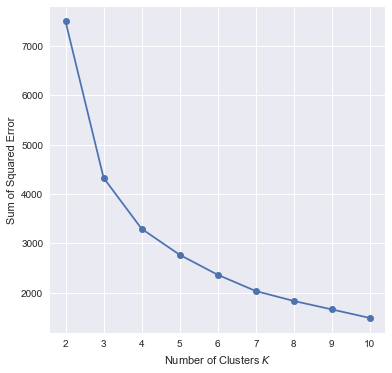

In [80]:
# Elbow method. We can get the sum of squared error (distances) using SKLearn's .inertia_ attribute.
sse=[]
clusters = [2,3,4,5,6,7,8,9,10]
for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfmDF_rescale)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6,6))
plt.plot(clusters, sse, '-o')
plt.xlabel('Number of Clusters $K$')
plt.ylabel('Sum of Squared Error');

The curve starts to flatten (has an 'elbow') at K = 4.

In [81]:
# We also use another technique known as the silhouette score.
from sklearn.metrics import silhouette_score

# Train the model, and compute and print the silhouette score in our range of clusters K.
for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfmDF_rescale)

    labels = kmeans.labels_

    silhouette = silhouette_score(rfmDF_rescale, labels)
    print("For K = {0}, the silhouette score is {1}.".format(k, silhouette))

For K = 2, the silhouette score is 0.5255878684416422.
For K = 3, the silhouette score is 0.5010267635434055.
For K = 4, the silhouette score is 0.4735072310456671.
For K = 5, the silhouette score is 0.46179101077300727.
For K = 6, the silhouette score is 0.4134719439617897.
For K = 7, the silhouette score is 0.4075758819904055.
For K = 8, the silhouette score is 0.3918189602491027.
For K = 9, the silhouette score is 0.3757163412274349.
For K = 10, the silhouette score is 0.37636014307393656.


We now want to run the model with a few different starting assignments. We will then choose the random state that gives the lowest sum of squared error.

In [84]:
# Train the method with random starting assignments.
iterations = 100
sse = []
state = []
for i in range(iterations):
    rs = np.random.randint(0,1000)
    state.append(rs)
    kmeans = KMeans(n_clusters=4, random_state = rs)
    kmeans.fit(rfmDF_rescale)
    sse.append(kmeans.inertia_)

# Create dataframe with results.
randomResults = pd.DataFrame()
randomResults['RandomState'] = state
randomResults['SSE'] = sse

In [85]:
randomResults.loc[randomResults['SSE'] == randomResults['SSE'].min()]   

,RandomState,SSE
58,566,3292.98263


From the above table we see that we want any of the random states that give a minimal SSE. We will take random_state = 566.

In [86]:
# Final model with K = 4 and random_state = 566.
kmeans = KMeans(n_clusters = 4, random_state = 566)
kmeans.fit(rfmDF_rescale)

KMeans(n_clusters=4, random_state=566)

In [87]:
# We now assign the labels from the method to each customer.
rfm['ClusterID'] = kmeans.labels_
rfmDF_rescale['ClusterID'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClusterID
0,12346.0,325,2,0.00,1
1,12347.0,1,182,4310.00,0
2,12348.0,74,31,1797.24,3
3,12349.0,18,73,1757.55,3
4,12350.0,309,17,334.40,1


In [88]:
# We can print the frequency of each cluster label within our dataset.
print(rfm['ClusterID'].value_counts())

3    2208
1    1034
0     782
2     241
Name: ClusterID, dtype: int64


## Visualisation
We now try some different ways to visualise the clusters.

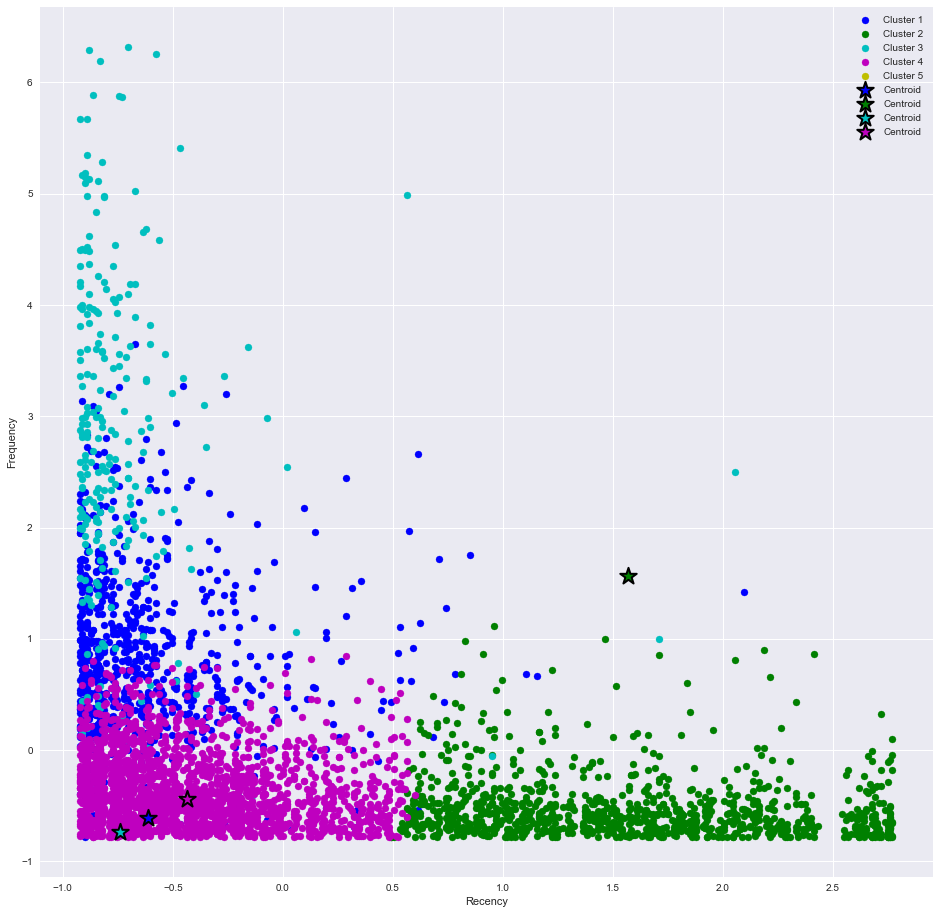

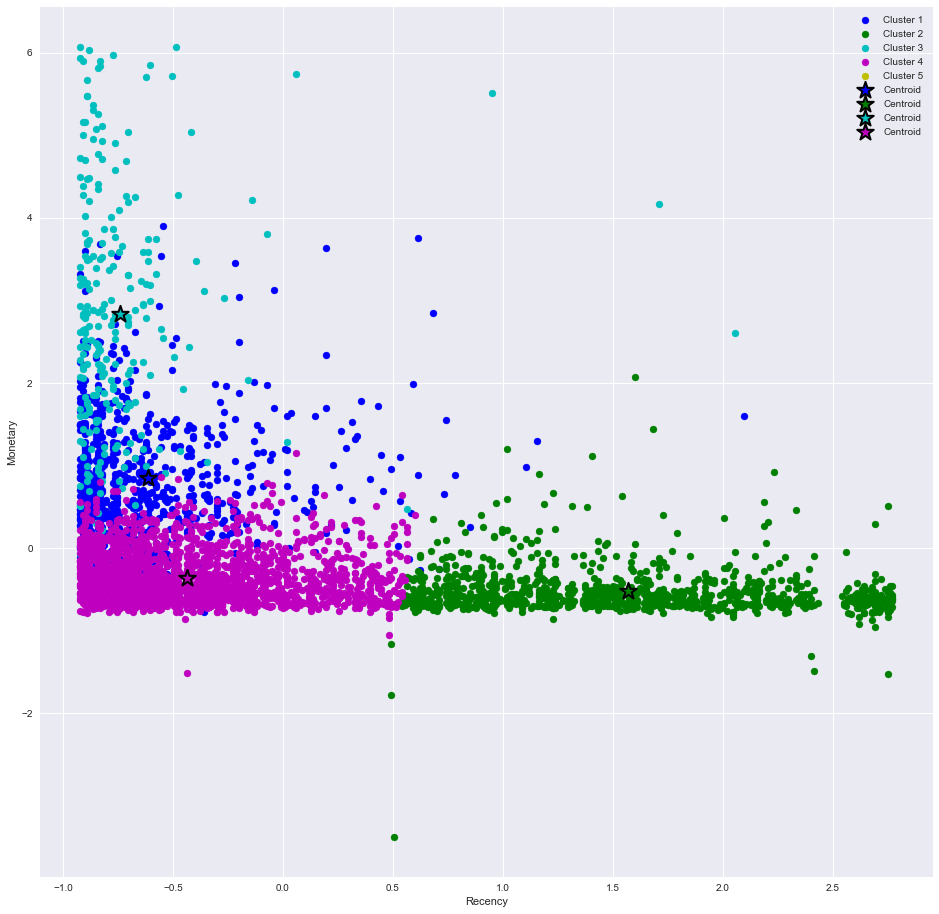

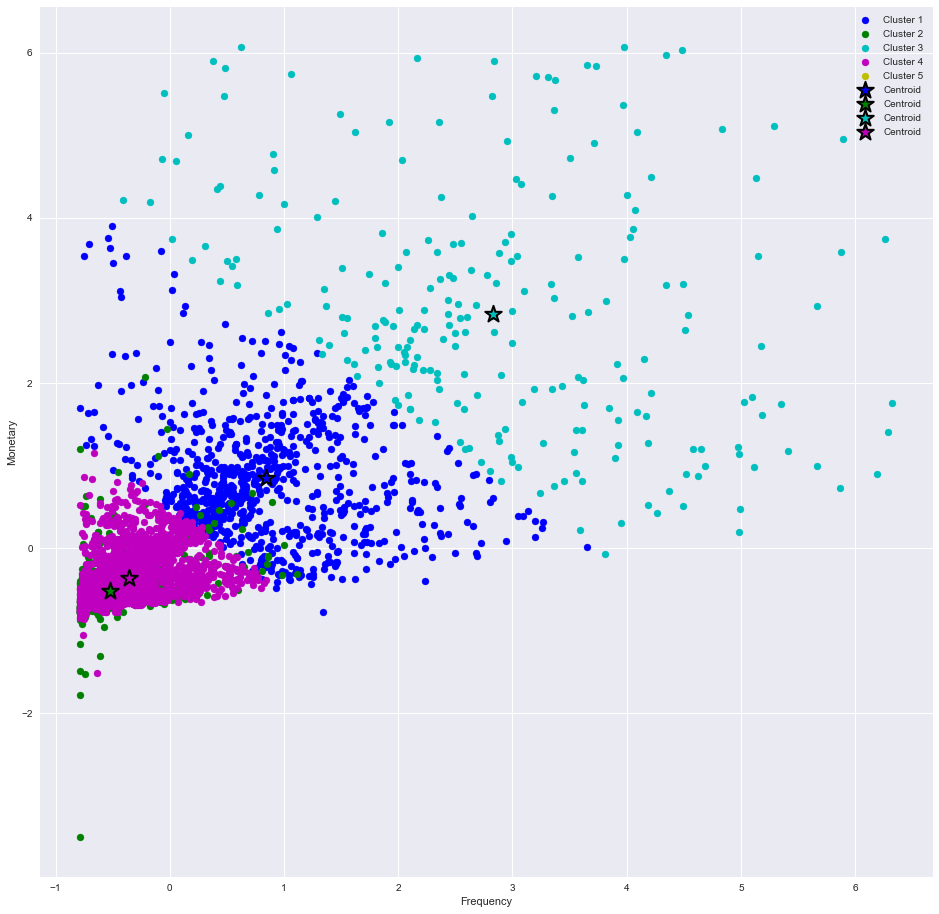

In [101]:
# We first look at some pairwise relations compared to the clustering using scatter plots coloured by cluster.
centroids = kmeans.cluster_centers_ # Get the centres of each cluster to put on plot

# Loop to get each pairwise combination of features.
for i in ['Recency', 'Frequency']:
    for j in ['Frequency', 'Monetary']:
        if i == j:
            continue
        else:
            fig, ax = plt.subplots(figsize=(16,16))

            xCentres = centroids[:, ['Recency', 'Frequency'].index(i)]
            yCentres = centroids[:, ['Frequency', 'Monetary'].index(j)]
            
            plt.scatter(rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 0, i], rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 0, j],
                            c='b', label='Cluster 1')
            plt.scatter(rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 1, i], rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 1, j],
                            c='g', label='Cluster 2')
            plt.scatter(rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 2, i], rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 2, j],
                            c='c', label='Cluster 3')
            plt.scatter(rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 3, i], rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 3, j],
                            c='m', label='Cluster 4')
            plt.scatter(rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 4, i], rfmDF_rescale.loc[rfmDF_rescale['ClusterID'] == 4, j],
                            c='y', label='Cluster 5')   
            for k in range(len(centroids)):
                colours = ['b','g','c','m','y']
                plt.scatter(xCentres[k], yCentres[k], c=colours[k], edgecolors='black', linewidth=2, marker='*', s=300, label='Centroid')   
            
            plt.legend()
            plt.xlabel(i)
            plt.ylabel(j);

<AxesSubplot:xlabel='ClusterID', ylabel='Recency'>

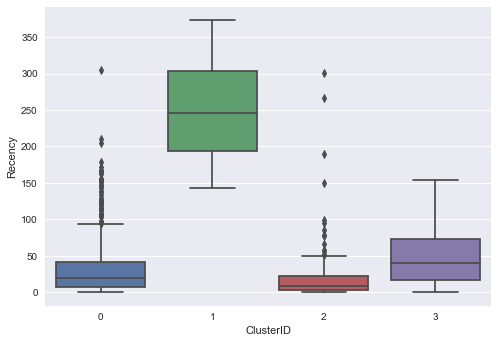

In [97]:
# Now use boxplots to visualise ClusterID vs the 3 features

# Recency
sns.boxplot(x='ClusterID', y='Recency', data=rfm)

<AxesSubplot:xlabel='ClusterID', ylabel='Frequency'>

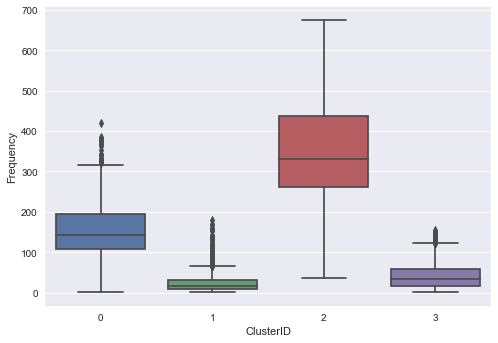

In [98]:
# Frequency
sns.boxplot(x='ClusterID', y='Frequency', data=rfm)

<AxesSubplot:xlabel='ClusterID', ylabel='Monetary'>

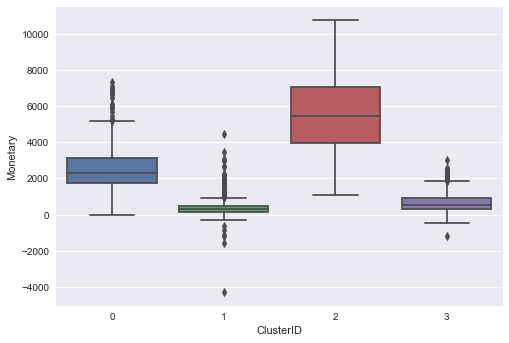

In [99]:
# Monetary
sns.boxplot(x='ClusterID', y='Monetary', data=rfm)